# LeNet


In [2]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
from torch import nn
from torchvision import datasets, transforms

In [32]:
transform_train = transforms.Compose([transforms.Resize((32,32)),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.RandomRotation(10),
                                      transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)),
                                      transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                               ])

transform = transforms.Compose([transforms.Resize((32,32)),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                               ])
training_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
testing_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

training_loader = torch.utils.data.DataLoader(training_dataset, batch_size=100, shuffle=True)
testing_loader = torch.utils.data.DataLoader(testing_dataset, batch_size = 100, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [33]:
def im_convert(tensor):
    image = tensor.cpu().clone().detach().numpy()
    image = image.transpose(1, 2, 0)
    image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
    image = image.clip(0, 1)
    return image

In [19]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

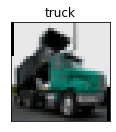

In [34]:
dataiter = iter(training_loader)
images, labels = dataiter.next()
fig = plt.figure(figsize=(25, 4))

for idx in np.arange(1):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
    plt.imshow(im_convert(images[idx]))
    ax.set_title(classes[labels[idx].item()])

In [35]:
# Define the model
class LeNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, 1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, 1, padding=1)
        self.conv3 = nn.Conv2d(32, 64, 3, 1, padding=1)
        self.fc1 = nn.Linear(4*4*64, 500)
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(500, 10)
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4*4*64)
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = self.fc2(x)
        return x

In [36]:
# Instantiate the model and move it to GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
model = LeNet().to(device)
model

LeNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=1024, out_features=500, bias=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
)

In [37]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

In [50]:
# A function to encapsulate the training loop
def training(model, criterion, optimizer, training_loader, testing_loader, epochs):
    train_loss_history = []
    train_acc_history = []
    test_loss_history = []
    test_acc_history = []

    for ep in range(epochs):

        train_loss = 0.0
        train_acc = 0.0
        test_loss = 0.0
        test_acc = 0.0
        
        model.train()
        for inputs, labels in training_loader:
            inputs,labels = inputs.to(device),labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            _, preds = torch.max(outputs, 1)
            train_loss += loss.item()
            train_acc += torch.sum(preds == labels.data)

        model.eval()
        for inputs, labels in testing_loader:
            inputs,labels = inputs.to(device),labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            _, preds = torch.max(outputs, 1)
            test_loss += loss.item()
            test_acc += torch.sum(preds == labels.data)

        train_epoch_loss = train_loss/len(training_loader.dataset)
        train_epoch_acc = train_acc.float()/ len(training_loader.dataset)
        train_loss_history.append(train_epoch_loss)
        train_acc_history.append(train_epoch_acc)

        test_epoch_loss = test_loss/len(testing_loader.dataset)
        test_epoch_acc = test_acc.float()/ len(testing_loader.dataset)
        test_loss_history.append(test_epoch_loss)
        test_acc_history.append(test_epoch_acc)
        print(f'Epoch {ep+1}/{epochs}:')
        print(f'Train loss: {train_epoch_loss:.4f}, Train accuracy: {train_epoch_acc.item():.4f}.')
        print(f'Test loss: {test_epoch_loss:.4f}, Test accuracy: {test_epoch_acc.item():.4f}.')

    return train_loss_history,train_acc_history,test_loss_history,test_acc_history

In [51]:
# Training process
train_loss_history,train_acc_history,test_loss_history,test_acc_history = training(
    model, criterion, optimizer, training_loader, testing_loader, epochs=15)


Epoch 1/15:
Train loss: 0.0075, Train accuracy: 0.7361.
Test loss: 0.0062, Test accuracy: 0.7840.
Epoch 2/15:
Train loss: 0.0074, Train accuracy: 0.7393.
Test loss: 0.0060, Test accuracy: 0.7925.
Epoch 3/15:
Train loss: 0.0074, Train accuracy: 0.7426.
Test loss: 0.0063, Test accuracy: 0.7826.
Epoch 4/15:
Train loss: 0.0073, Train accuracy: 0.7443.
Test loss: 0.0061, Test accuracy: 0.7869.
Epoch 5/15:
Train loss: 0.0072, Train accuracy: 0.7457.
Test loss: 0.0062, Test accuracy: 0.7865.
Epoch 6/15:
Train loss: 0.0072, Train accuracy: 0.7496.
Test loss: 0.0062, Test accuracy: 0.7889.
Epoch 7/15:
Train loss: 0.0071, Train accuracy: 0.7497.
Test loss: 0.0061, Test accuracy: 0.7905.
Epoch 8/15:
Train loss: 0.0071, Train accuracy: 0.7511.
Test loss: 0.0061, Test accuracy: 0.7936.
Epoch 9/15:
Train loss: 0.0071, Train accuracy: 0.7502.
Test loss: 0.0060, Test accuracy: 0.7938.
Epoch 10/15:
Train loss: 0.0071, Train accuracy: 0.7508.
Test loss: 0.0060, Test accuracy: 0.7952.
Epoch 11/15:
Train 

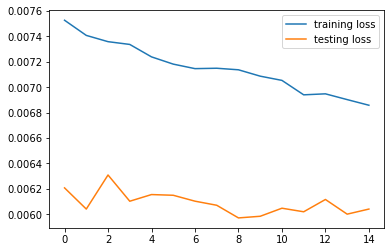

In [52]:
plt.plot(train_loss_history, label='training loss')
plt.plot(test_loss_history, label='testing loss')
plt.legend()

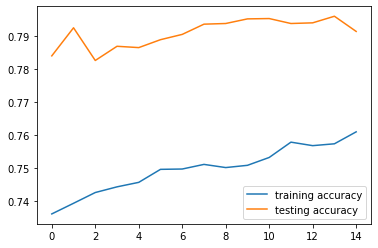

In [53]:
plt.plot(train_acc_history, label='training accuracy')
plt.plot(test_acc_history, label='testing accuracy')
plt.legend()

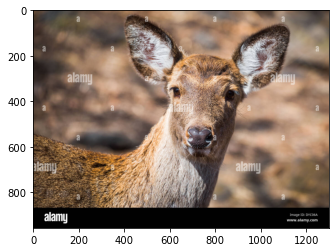

In [59]:
import PIL.ImageOps
import requests
from PIL import Image

url = 'https://c8.alamy.com/comp/DYC06A/hornless-reindeer-at-zoo-DYC06A.jpg'
response = requests.get(url, stream = True)
img = Image.open(response.raw)
plt.imshow(img)

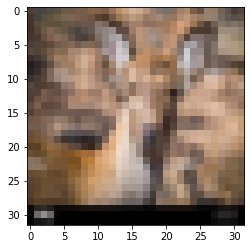

In [56]:
img = transform(img) 
plt.imshow(im_convert(img))

In [57]:
image = img.to(device).unsqueeze(0)
output = model(image)
_, pred = torch.max(output, 1)
print(classes[pred.item()])

cat


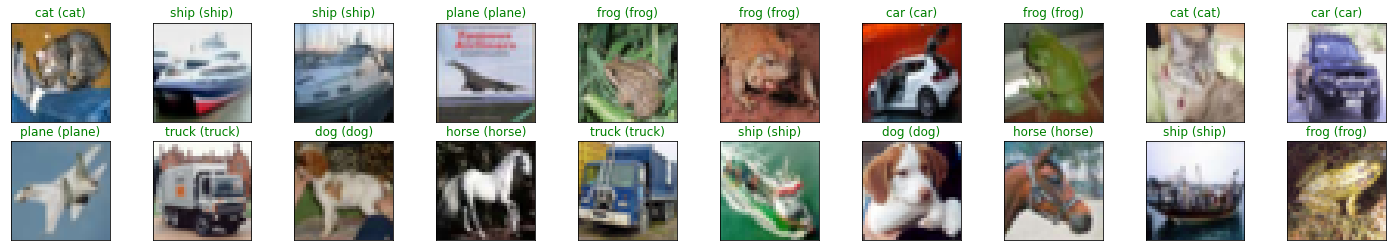

In [58]:
dataiter = iter(testing_loader)
images, labels = dataiter.next()
images = images.to(device)
labels = labels.to(device)
output = model(images)
_, preds = torch.max(output, 1)

fig = plt.figure(figsize=(25, 4))

for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
    plt.imshow(im_convert(images[idx]))
    ax.set_title("{} ({})".format(str(classes[preds[idx].item()]), str(classes[labels[idx].item()])), color=("green" if preds[idx]==labels[idx] else "red"))
